# Hospital Readmissions Data Analysis and Recommendations for Reduction

### Background
In October 2012, the US government's Center for Medicare and Medicaid Services (CMS) began reducing Medicare payments for Inpatient Prospective Payment System hospitals with excess readmissions. Excess readmissions are measured by a ratio, by dividing a hospital’s number of “predicted” 30-day readmissions for heart attack, heart failure, and pneumonia by the number that would be “expected,” based on an average hospital with similar patients. A ratio greater than 1 indicates excess readmissions.

### Exercise Directions

In this exercise, you will:
+ critique a preliminary analysis of readmissions data and recommendations (provided below) for reducing the readmissions rate
+ construct a statistically sound analysis and make recommendations of your own 

More instructions provided below. Include your work **in this notebook and submit to your Github account**. 

### Resources
+ Data source: https://data.medicare.gov/Hospital-Compare/Hospital-Readmission-Reduction/9n3s-kdb3
+ More information: http://www.cms.gov/Medicare/medicare-fee-for-service-payment/acuteinpatientPPS/readmissions-reduction-program.html
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
****

In [357]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bokeh.plotting as bkp
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import stats

In [356]:
states = {
        'AK': 'O',
        'AL': 'S',
        'AR': 'S',
        'AS': 'O',
        'AZ': 'W',
        'CA': 'W',
        'CO': 'W',
        'CT': 'N',
        'DC': 'N',
        'DE': 'N',
        'FL': 'S',
        'GA': 'S',
        'GU': 'O',
        'HI': 'O',
        'IA': 'M',
        'ID': 'W',
        'IL': 'M',
        'IN': 'M',
        'KS': 'M',
        'KY': 'S',
        'LA': 'S',
        'MA': 'N',
        'MD': 'N',
        'ME': 'N',
        'MI': 'W',
        'MN': 'M',
        'MO': 'M',
        'MP': 'O',
        'MS': 'S',
        'MT': 'W',
        'NA': 'O',
        'NC': 'S',
        'ND': 'M',
        'NE': 'W',
        'NH': 'N',
        'NJ': 'N',
        'NM': 'W',
        'NV': 'W',
        'NY': 'N',
        'OH': 'M',
        'OK': 'S',
        'OR': 'W',
        'PA': 'N',
        'PR': 'O',
        'RI': 'N',
        'SC': 'S',
        'SD': 'M',
        'TN': 'S',
        'TX': 'S',
        'UT': 'W',
        'VA': 'S',
        'VI': 'O',
        'VT': 'N',
        'WA': 'W',
        'WI': 'M',
        'WV': 'S',
        'WY': 'W'
}

def ecdf(data):
    """Compute( ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n=len(data)
    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y



def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates



def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data)))

def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""

    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)

        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)

    return perm_replicates

def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets: data
    data = np.concatenate((data1, data2))

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2


def draw_bs_pairs_linreg(x, y, size=1):
    """Perform pairs bootstrap for linear regression."""

    # Set up array of indices to sample from: inds
    inds = np.arange(len(x))

    # Initialize replicates: bs_slope_reps, bs_intercept_reps
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x, bs_y, 1)

    return bs_slope_reps, bs_intercept_reps


In [376]:
# read in readmissions data provided
hospital_read_df = pd.read_csv('data/cms_hospital_readmissions.csv')
hospital_read_df.head()

,Hospital Name,Provider Number,State,Measure Name,Number of Discharges,Footnote,Excess Readmission Ratio,Predicted Readmission Rate,Expected Readmission Rate,Number of Readmissions,Start Date,End Date
0,FROEDTERT MEMORIAL LUTHERAN HOSPITAL,520177,WI,READM-30-HIP-KNEE-HRRP,242,NaN,1.9095,10.8,5.6,38.0,07/01/2010,06/30/2013
1,PROVIDENCE HOSPITAL,90006,DC,READM-30-HIP-KNEE-HRRP,247,NaN,1.7521,9.2,5.3,33.0,07/01/2010,06/30/2013
2,BEAUFORT COUNTY MEMORIAL HOSPITAL,420067,SC,READM-30-HIP-KNEE-HRRP,586,NaN,1.5836,7.6,4.8,53.0,07/01/2010,06/30/2013
3,ADVOCATE CHRIST HOSPITAL & MEDICAL CENTER,140208,IL,READM-30-HIP-KNEE-HRRP,965,NaN,1.5760,9.0,5.7,95.0,07/01/2010,06/30/2013
4,BRAZOSPORT REGIONAL HEALTH SYSTEM,450072,TX,READM-30-HIP-KNEE-HRRP,149,NaN,1.5308,8.2,5.4,20.0,07/01/2010,06/30/2013


****
## Preliminary Analysis

In [384]:
# deal with missing and inconvenient portions of data 
clean_hospital_read_df = hospital_read_df[hospital_read_df['Number of Discharges'] != 'Not Available']
clean_hospital_read_df.loc[:, 'Number of Discharges'] = clean_hospital_read_df['Number of Discharges'].astype(int)
clean_hospital_read_df = clean_hospital_read_df.sort_values('Number of Discharges')
clean_hospital_read_df['Region'] = clean_hospital_read_df['State'].map(states)

/home/bigley/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


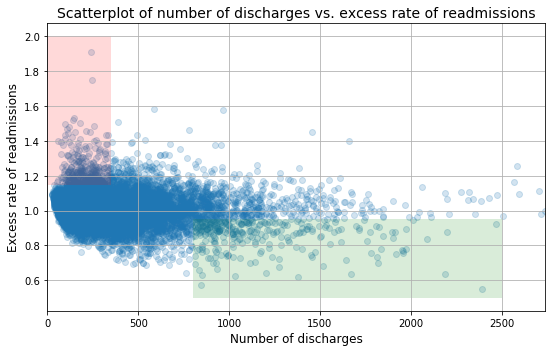

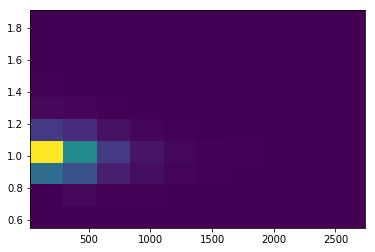

0.05346346519260667
0.04911591355599214

0.032648125755743655
0.017026850032743943


In [385]:
# generate a scatterplot for number of discharges vs. excess rate of readmissions
# lists work better with matplotlib scatterplot function
x = [a for a in clean_hospital_read_df['Number of Discharges'][81:-3]]
y = list(clean_hospital_read_df['Excess Readmission Ratio'][81:-3])

fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(x, y,alpha=0.2)

ax.fill_between([0,350], 1.15, 2, facecolor='red', alpha = .15, interpolate=True)
ax.fill_between([800,2500], .5, .95, facecolor='green', alpha = .15, interpolate=True)

ax.set_xlim([0, max(x)])
ax.set_xlabel('Number of discharges', fontsize=12)
ax.set_ylabel('Excess rate of readmissions', fontsize=12)
ax.set_title('Scatterplot of number of discharges vs. excess rate of readmissions', fontsize=14)

ax.grid(True)
fig.tight_layout()
plt.show()
plt.hist2d(x,y, normed = True)
plt.show()

#totals = x*y

print(len(clean_hospital_read_df[clean_hospital_read_df['Excess Readmission Ratio'] >1.15])/len(clean_hospital_read_df))
print(len(small[small['Excess Readmission Ratio'] >1.15])/len(small))
print()
print(len(clean_hospital_read_df[clean_hospital_read_df['Excess Readmission Ratio'] <0.85])/len(clean_hospital_read_df))
print(len(large[large['Excess Readmission Ratio'] <0.85])/len(small))



Text(0.5,1,'Scatterplot of number of discharges vs. number of readmissions')

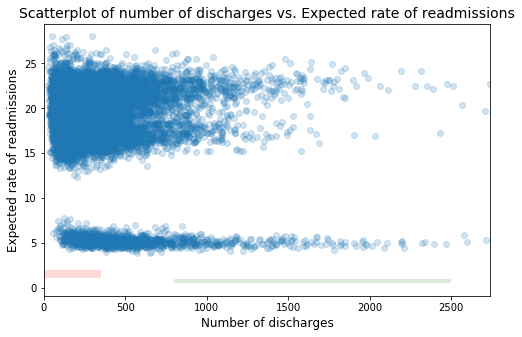

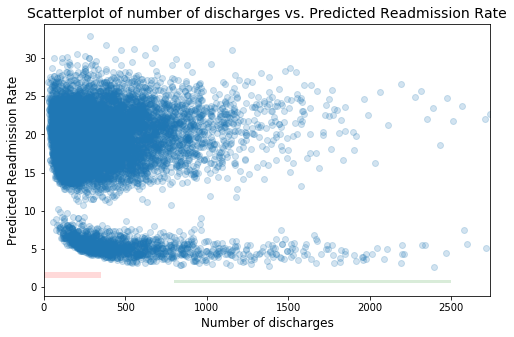

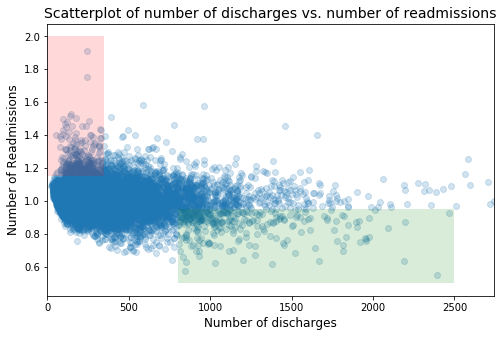

In [366]:
# generate a scatterplot for number of discharges vs. excess rate of readmissions
# lists work better with matplotlib scatterplot function
x = clean_hospital_read_df['Number of Discharges'][81:-3]
y = clean_hospital_read_df['Expected Readmission Rate'][81:-3]

fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(x, y,alpha=0.2, label=clean_hospital_read_df['Region'])
ax.fill_between([0,350], 1.15, 2, facecolor='red', alpha = .15, interpolate=True)
ax.fill_between([800,2500], .5, .95, facecolor='green', alpha = .15, interpolate=True)

ax.set_xlim([0, max(x)])
ax.set_xlabel('Number of discharges', fontsize=12)
ax.set_ylabel('Expected rate of readmissions', fontsize=12)
ax.set_title('Scatterplot of number of discharges vs. Expected rate of readmissions', fontsize=14)
# generate a scatterplot for number of discharges vs. excess rate of readmissions
# lists work better with matplotlib scatterplot function






x = clean_hospital_read_df['Number of Discharges'][81:-3]
y = clean_hospital_read_df['Predicted Readmission Rate'][81:-3]

fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(x, y,alpha=0.2, label=clean_hospital_read_df['Region'])
ax.fill_between([0,350], 1.15, 2, facecolor='red', alpha = .15, interpolate=True)
ax.fill_between([800,2500], .5, .95, facecolor='green', alpha = .15, interpolate=True)

ax.set_xlim([0, max(x)])
ax.set_xlabel('Number of discharges', fontsize=12)
ax.set_ylabel('Predicted Readmission Rate', fontsize=12)
ax.set_title('Scatterplot of number of discharges vs. Predicted Readmission Rate', fontsize=14)


# generate a scatterplot for number of discharges vs. excess rate of readmissions
# lists work better with matplotlib scatterplot function






x = clean_hospital_read_df['Number of Discharges'][81:-3]
y = clean_hospital_read_df['Excess Readmission Ratio'][81:-3]

fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(x, y,alpha=0.2, label=clean_hospital_read_df['Region'])
ax.fill_between([0,350], 1.15, 2, facecolor='red', alpha = .15, interpolate=True)
ax.fill_between([800,2500], .5, .95, facecolor='green', alpha = .15, interpolate=True)

ax.set_xlim([0, max(x)])
ax.set_xlabel('Number of discharges', fontsize=12)
ax.set_ylabel('Number of Readmissions', fontsize=12)
ax.set_title('Scatterplot of number of discharges vs. number of readmissions', fontsize=14)


****

## Preliminary Report

Read the following results/report. While you are reading it, think about if the conclusions are correct, incorrect, misleading or unfounded. Think about what you would change or what additional analyses you would perform.

**A. Initial observations based on the plot above**
+ Overall, rate of readmissions is trending down with increasing number of discharges
+ With lower number of discharges, there is a greater incidence of excess rate of readmissions (area shaded red)
+ With higher number of discharges, there is a greater incidence of lower rates of readmissions (area shaded green) 

**B. Statistics**
+ In hospitals/facilities with number of discharges < 100, mean excess readmission rate is 1.023 and 63% have excess readmission rate greater than 1 
+ In hospitals/facilities with number of discharges > 1000, mean excess readmission rate is 0.978 and 44% have excess readmission rate greater than 1 

**C. Conclusions**
+ There is a significant correlation between hospital capacity (number of discharges) and readmission rates. 
+ Smaller hospitals/facilities may be lacking necessary resources to ensure quality care and prevent complications that lead to readmissions.

**D. Regulatory policy recommendations**
+ Hospitals/facilties with small capacity (< 300) should be required to demonstrate upgraded resource allocation for quality care to continue operation.
+ Directives and incentives should be provided for consolidation of hospitals and facilities to have a smaller number of them with higher capacity and number of discharges.

****
### Exercise

Include your work on the following **in this notebook and submit to your Github account**. 

A. Do you agree with the above analysis and recommendations? Why or why not?
   
B. Provide support for your arguments and your own recommendations with a statistically sound analysis:

   1. Setup an appropriate hypothesis test.
   2. Compute and report the observed significance value (or p-value).
   3. Report statistical significance for $\alpha$ = .01. 
   4. Discuss statistical significance and practical significance. Do they differ here? How does this change your recommendation to the client?
   5. Look at the scatterplot above. 
      - What are the advantages and disadvantages of using this plot to convey information?
      - Construct another plot that conveys the same information in a more direct manner.



You can compose in notebook cells using Markdown: 
+ In the control panel at the top, choose Cell > Cell Type > Markdown
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
****

I would disagree with several parts of the analysis above. First, the conclusion that hospitals should be consolidated is a questionable one. Even if all the other analysis was correct, it's not the number of discharges that's causing a lower rate of readmissions, it's a mess of factors that come along with being a larger hospital that are being captured by that number.

The green shaded area is misleading because it ignores that the 6 largest hospitals have excess ratios larger than one.



Practical and statistical significance do differ here. Statistically we have shown that there is a significant chance that small hospitals have worse readmission rates than larger hospitals. This may lead us to want to invest more in smaller hospitals, however, the largest 10% of hospitals serves more patients than the lower 50% so small improvements in readmissions rates at these hospitals will effect more people than larger increases to readmission rates at smaller hospitals. 

In [369]:
# Your turn



In [393]:
clean_hospital_read_df.dropna(subset=['Excess Readmission Ratio'], inplace=True)
#clean_hospital_read_df = clean_hospital_read_df[['Excess Readmission Ratio', 'Number of Discharges']]
excess =clean_hospital_read_df['Excess Readmission Ratio']
num = clean_hospital_read_df['Number of Discharges']

In [401]:
small = clean_hospital_read_df[clean_hospital_read_df['Number of Discharges'] < 300]
large = clean_hospital_read_df[clean_hospital_read_df['Number of Discharges'] >=300]
print(sum(small[small['Excess Readmission Ratio'] > 1.1]['Number of Discharges']))
print(sum(large[large['Excess Readmission Ratio'] > 1.1]['Number of Discharges']))

#print(small.mean(), small.std())
#print(large.mean(), large.std())
#max(small['Excess Readmission Ratio'])
#print(len(small), len(large), len(clean_hospital_read_df))
np.percentile(clean_hospital_read_df['Number of Discharges'], [53, 90])
#large

129322
433125


array([ 299. ,  726.4])

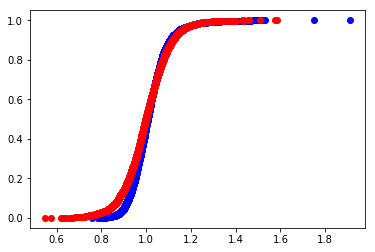

In [189]:
small_ec_x, small_ec_y = ecdf(small['Excess Readmission Ratio'])
large_ec_x, large_ec_y = ecdf(large['Excess Readmission Ratio'])
plt.plot(small_ec_x, small_ec_y, 'o', color='blue')
plt.plot(large_ec_x, large_ec_y, 'o', color='red')
plt.legend()
plt.show()

In [381]:
print(stats.linregress(small['Number of Discharges'], small['Excess Readmission Ratio'] ))
print(stats.linregress(large['Number of Discharges'], large['Excess Readmission Ratio'] ))
print(stats.linregress(clean_hospital_read_df['Number of Discharges'], clean_hospital_read_df['Excess Readmission Ratio'] ))

LinregressResult(slope=-4.308154565971546e-05, intercept=1.021540865675086, rvalue=-0.036488713252481882, pvalue=0.0043432280064244306, stderr=1.5099585291864834e-05)
LinregressResult(slope=-2.7181962935919786e-05, intercept=1.0178181895228624, rvalue=-0.094630928736816805, pvalue=0.0019622156479852169, stderr=8.7582189041274042e-06)
LinregressResult(slope=-2.9010517330570697e-05, intercept=1.018106147373357, rvalue=-0.097397943510793519, pvalue=1.2225473776734486e-25, stderr=2.7649127349110587e-06)


In [382]:
slope_bs, inter_bs = draw_bs_pairs_linreg(clean_hospital_read_df['Number of Discharges'].values, clean_hospital_read_df['Excess Readmission Ratio'].values, size = 10000)
np.percentile(slope_bs, [2.5, 97.5])

array([ -3.56007145e-05,  -2.23514725e-05])

In [399]:
stats.ttest_ind(small['Excess Readmission Ratio'], large['Excess Readmission Ratio'])

Ttest_indResult(statistic=8.384446244560591, pvalue=5.6895380893335379e-17)

In [398]:
# Construct arrays of data: black, white
perm_replicates_bs = np.empty(10000)
perm_replicates_bs_w = np.empty(10000)
for i in range(10000):
    perm_replicates_bs[i] = draw_bs_reps(small['Excess Readmission Ratio'], np.mean)
    perm_replicates_bs_w[i] = draw_bs_reps(large['Excess Readmission Ratio'], np.mean)
    
    perm_replicates_diff = perm_replicates_bs_w -perm_replicates_bs
# Compute and print p-value: p
p = np.sum(perm_replicates_diff >= 0 ) / len(perm_replicates_diff)
print('p-value =', p)


print(np.percentile(perm_replicates_diff, [2.5, 97.5]))

p-value = 0.0
[-0.01776482 -0.01093793]
